<a href="https://colab.research.google.com/github/cosh14/Project/blob/master/Domains%20wrapped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.0 1.9945884782750358 1.9657686824472829 1.957611778604206
242 140
2.0 1.9929741452592231 1.9775548223624568 1.9720280434314486
J grid expected values =33880 and J grid returned values = 33880
(242, 140)


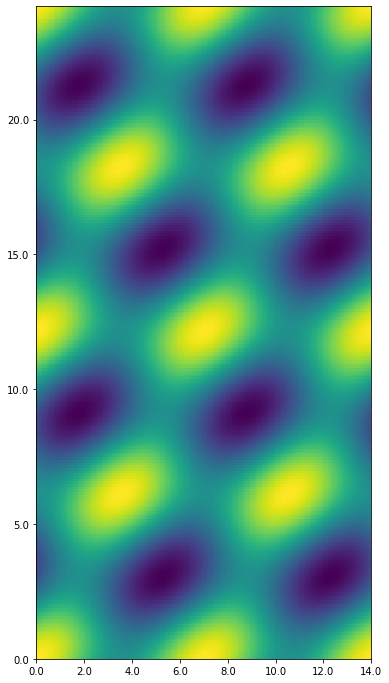

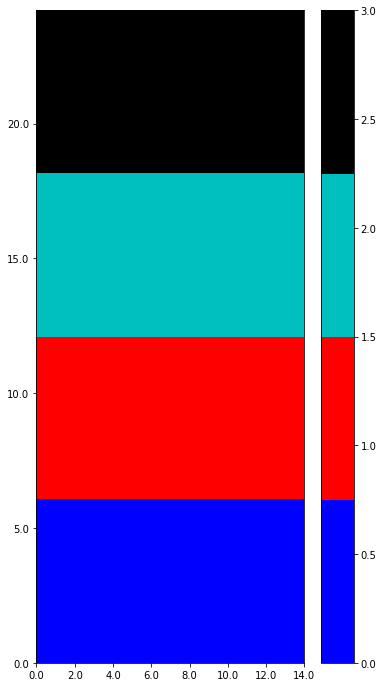

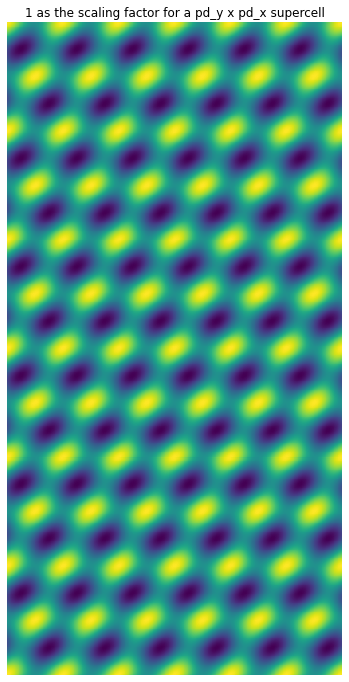

In [188]:
import numpy as np 
np.set_printoptions(threshold=1000)
import numba as nb
from numba import jit
import matplotlib.pyplot as plt 
from scipy.constants import pi
from matplotlib import colors as c
import matplotlib.gridspec as gridspec
import numpy.ma as ma
from numpy.ma.core import concatenate, size
from numpy.random import randint as rd 
from numpy.random import rand 
from matplotlib.pyplot import arrow, axis, figure, imshow, pcolormesh, rc_context, title
from matplotlib.colors import from_levels_and_colors as lc
import itertools 
import time 
plt.rcParams["figure.figsize"] = (8,6)
start_time = time.time() 
d = 2.0
do = 2.01
bin_freq = 0.1
e = bin_freq/1.08
#formatting of arrays in numpy is (y,x) see shapes in https://note.nkmk.me/en/python-numpy-ndarray-ndim-shape-size/
K1 = np.array([(4*pi)/(d*np.sqrt(3)),0])
K2 = np.array([(4*pi)/(do*np.sqrt(3)),0])
K3 = np.array([(-2*pi)/(d*np.sqrt(3)),2*pi/d])
K4 = np.array([(-2*pi)/(do*np.sqrt(3)),2*pi/do])

#periodicity in x ~ 122, range ~ [119,123]
#periodicity in y ~ 140
# all definitions for d=2.0, do=2.01, bin freq = 0.1
pd_x = 70
pd_y = 120
N=1

J = np.zeros((N*pd_y,N*pd_x))
R_x = np.zeros((N*pd_y,N*pd_x))
R_y = np.zeros((N*pd_y,N*pd_x))

for i in range (N*pd_y):
  for j in range (N*pd_x): 
    R = np.array([i*bin_freq,j*bin_freq])
    R_x[i][j] = j*bin_freq
    R_y[i][j] = i*bin_freq
    J[i,j] = np.cos((180/np.pi)*(np.dot(R,K4-K3)))+(np.cos((180/np.pi)*(np.dot(R,K2-K1))))
    

print(J[0][0], J[0][-1], J[-1][-1], J[-1][0])

check_J = J[0][-1]
while check_J < 1.999:
  pd_x+=1
  cR = np.array([0,N*pd_x*bin_freq])
  check_J = np.cos(180/pi*np.dot(cR,K2-K1)) + np.cos(180/pi*np.dot(cR,K4-K3))

check_J = J[-1][0]
while check_J < 1.999:
  pd_y+=1
  cR = np.array([N*pd_y*bin_freq,0])
  check_J = np.cos(180/pi*np.dot(cR,K2-K1)) + np.cos(180/pi*np.dot(cR,K4-K3))

#pd_x+=1
pd_y-=1
print(pd_y,pd_x)

J = np.zeros((N*pd_y,N*pd_x))
J_dmn_x = np.zeros((N*pd_y,N*pd_x))
J_dmn_y = np.zeros((N*pd_y,N*pd_x))
R_x = np.zeros((N*pd_y,N*pd_x))
R_y = np.zeros((N*pd_y,N*pd_x))

for i in range (N*pd_y):
  for j in range (N*pd_x): 
    R = np.array([i*bin_freq,j*bin_freq])
    R_x[i][j] = j*bin_freq
    R_y[i][j] = i*bin_freq
    J[i,j] = np.cos((180/np.pi)*(np.dot(R,K4-K3)))+(np.cos((180/np.pi)*(np.dot(R,K2-K1))))
    J_dmn_x[i,j] = np.floor(-1/(0.01736*2*pi)*np.dot(R,K2-K1))
    J_dmn_y[i,j] = np.floor(-1/(0.01736*2*pi)*np.dot(R,K4-K3)) 

print(J[0][0], J[0][-1], J[-1][-1], J[-1][0])

print("J grid expected values =%d and J grid returned values = %d" %((N*N*pd_y*pd_x) ,J.size)) #<- This does it

print(J.shape)

fig, ax = plt.subplots(figsize=(6,12))
pcolormesh(J)
ticksx = ax.get_xticks()*bin_freq
ax.set_xticklabels(ticksx)
ticksy = ax.get_yticks()*bin_freq
ax.set_yticklabels(ticksy)
plt.show()

fig, ax = plt.subplots(figsize=(6,12))
cMap = c.ListedColormap(['b','r','c','k'])
pcolormesh(J_dmn_x, cmap=cMap) 
ticksx = ax.get_xticks()*bin_freq
ax.set_xticklabels(ticksx)
ticksy = ax.get_yticks()*bin_freq
ax.set_yticklabels(ticksy)
plt.colorbar()
plt.show()


def VisualMeshCheck(n): #useless mostly, visual check for periodicity
  plt.figure(figsize = (6,12))
  gs1 = gridspec.GridSpec(n,n)
  gs1.update(wspace=0.0, hspace=0.0)
  for i in range(n*n):
    #figure(num=None, figsize=(51, 25.5), dpi=120, facecolor='w', edgecolor='k')
    plt.subplot(gs1[i])
    plt.pcolormesh(J)
    plt.axis('off')
    plt.grid('false')
    if i==1:
      plt.title('%i as the scaling factor for a pd_y x pd_x supercell' %N)
VisualMeshCheck(3)


In [319]:
x_l = R_x[-1][-1]
y_l = R_y[-1][-1]
print(x_l,y_l)
sf = 0.1 #scaling factor to get grid
err = np.finfo(float).eps
print(err)

13.9 24.1
2.220446049250313e-16


In [320]:
@jit(nopython=True)
def Jdomassignment(coordinates):
  J_usable = np.zeros(len(coordinates))
  J_dmn_nr_x = np.zeros(len(coordinates))
  J_dmn_nr_xy = np.zeros(len(coordinates))
  J_dmn_nr = np.zeros(len(coordinates))
  
  for i in range (len(coordinates)):
    cd = np.array([coordinates[i][1],coordinates[i][0]])
    J_usable[i] = np.cos(180/pi*np.dot(cd,K2-K1)) + np.cos(180/pi*np.dot(cd,K4-K3))
    J_dmn_nr_x[i] = np.floor(-1/(0.01736*2*pi)*np.dot(cd,K2-K1))
    J_dmn_nr_xy[i] = np.floor(-1/(0.01736*2*pi)*np.dot(cd,K4-K3)) 
    J_dmn_nr[i] = 10*J_dmn_nr_x[i] + J_dmn_nr_xy[i]
  
  return J_usable,J_dmn_nr,J_dmn_nr_x, J_dmn_nr_xy


In [321]:
def CalcJ(sf):
  store_x_1 = np.arange(0,x_l+np.finfo(float).eps,d*sf)  
  store_x_2 = np.arange(d*sf*0.5,x_l+np.finfo(float).eps,d*sf)
  store_y_1 = np.arange(0,y_l+np.finfo(float).eps,d*0.866*2*sf)
  store_y_2 = np.arange(d*sf*0.866,y_l+np.finfo(float).eps,d*0.866*2*sf)
  xx, yy = np.meshgrid(store_x_1,store_y_1)
  ww, tt = np.meshgrid(store_x_2,store_y_2)
  xGridSize = len(store_x_1)+len(store_x_2) #each dimension includes a blank/masked element hence the sum
  yGridSize = len(store_y_1)+len(store_y_2)
  #print(xGridSize,yGridSize)

  temp_x = xx.tolist()
  temp_y = yy.tolist()
  set_1 = list(zip(temp_x[0], temp_y[0]))
  for i in range (1,len(store_y_1)):
      temp = list(zip(temp_x[i], temp_y[i]))
      for j in range (len(store_x_1)):
          set_1.append(temp[j])  

  temp_xo = ww.tolist()
  temp_yo = tt.tolist()
  set_2 = list(zip(temp_xo[0], temp_yo[0]))
  for i in range (1,len(store_y_2)):
      temp = list(zip(temp_xo[i], temp_yo[i]))
      for j in range (len(store_x_2)):
          set_2.append(temp[j])  
  
  del store_x_1
  del store_x_2
  del store_y_1
  del store_y_2

  coordinates = set_1 + set_2
  tx = np.zeros(len(coordinates))
  ty = np.zeros(len(coordinates))

  for i in range(len(coordinates)):
      tx [i] = coordinates[i][0]*(1/bin_freq) #tx only stores all x values (abcissa) of the coordinates list for plotting purposes
      ty [i] = coordinates[i][1]*(1/bin_freq)
    
  coord_x = tx.tolist()
  coord_y = ty.tolist()

  J_usable,J_dmn_nr,J_dmn_nr_x, J_dmn_nr_xy = Jdomassignment(nb.typed.List(coordinates))

  return coordinates, J_usable, tx, ty, xGridSize, yGridSize, J_dmn_nr,J_dmn_nr_x, J_dmn_nr_xy

print(CalcJ (sf)[5])


140


In [322]:
def plotJ(sf, bl):  #bl = 1 for annotations or 0 for no annotations
  print(J.shape)
  coordinates,J_usable,tx,ty,J_dmn_nr = CalcJ(sf)[0],CalcJ(sf)[1],CalcJ(sf)[2],CalcJ(sf)[3],CalcJ(sf)[6]
  print('Number of triangular points to be used = %d' %len(coordinates))
  fig, ax = plt.subplots(figsize=(12,24))
  style = dict(size=10, color='b')
  pcolormesh(J, alpha = 0.25)
  ax.scatter(tx,ty,marker='o',c = 'r',s=10)
  if bl ==1 :
    for i in range (len(coordinates)):
      ax.text(tx[i],ty[i],"(%.1f,%.3f) J=%.4f %.5f" %(coordinates[i][0],coordinates[i][1],J_usable[i],J_dmn_nr[i]),**style)
  ticksx = ax.get_xticks()*bin_freq
  ax.set_xticklabels(ticksx)
  ticksy = ax.get_yticks()*bin_freq
  ax.set_yticklabels(ticksy)
  plt.title('Scaling factor = %.3f' %sf)
  plt.show()

In [323]:
sf_p = 1 #principal scaling factor to define domains
J_usa = CalcJ(sf_p)[1]
val = J_usa[1]
while val < 1.999:
  sf_p+=0.01 
  J_usa= CalcJ(sf_p)[1]
  val = J_usa[1]

print('%.3f' %sf_p)
#plotJ(sf,0)
#plotJ(sf_p,1)

3.490


In [324]:
sigma = 2 # 1: cold start, 2:hot start

In [325]:
@jit(nopython=True)
def TempFastFunc(ly,lx):
    ctr = 0
    mask_array = np.ones((ly,lx))
    J_grid_val = np.zeros((ly,lx))
    J_db_val = np.zeros((ly,lx))
    #config = (2*rd(0,sigma,(ly,lx)))-1
    #config = (2*rd(0,1,(ly,lx)))-1
    config = (2*rd(0,2,(ly,lx)))-1
    for i in range(ly):
      if (i%2==0):
        for j in range(lx):
              if (((i+j)%2)==0):
                  J_grid_val[i][j] = J_usable[ctr]
                  J_db_val[i][j] = J_dom_nr[ctr]
                  ctr+=1
    for i in range(ly):
      if (i%2!=0):
        for j in range(lx):
              if (((i+j)%2)==0):
                  J_grid_val[i][j] = J_usable[ctr]
                  J_db_val[i][j] = J_dom_nr[ctr]
                  ctr+=1
    for i in range(ly):
      for j in range(lx):
        if (((i+j)%2)==0):
          mask_array[i][j] = 0
    return config, J_grid_val, J_db_val, mask_array


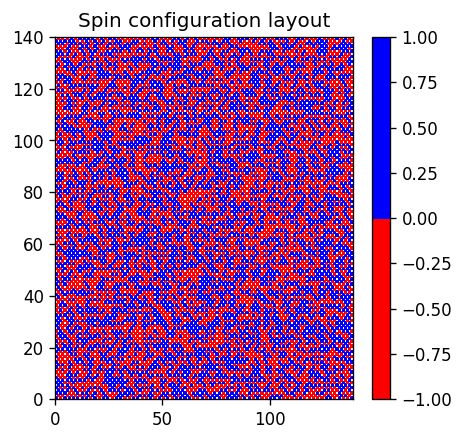

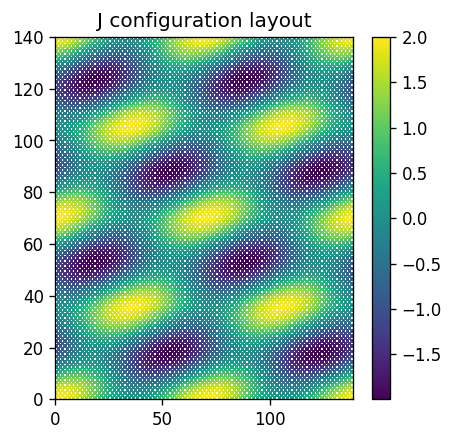

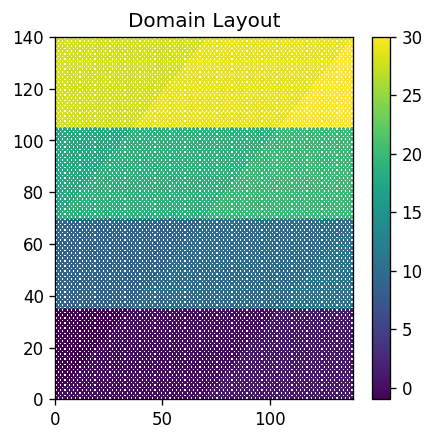

In [326]:
def GenerateTriLattice(ly,lx):
    config, J_grid_val, J_db_val, mask_array = TempFastFunc (ly,lx)
    use_config = ma.array(config, mask=mask_array)
    J_grid = ma.array(J_grid_val,mask=mask_array)
    J_db = ma.array(J_db_val,mask=mask_array)
    return use_config,J_grid,mask_array,J_db


J_usable, J_dom_nr, xGridSize, yGridSize = CalcJ(sf)[1], CalcJ(sf)[6], CalcJ(sf)[4], CalcJ(sf)[5]
cMap = c.ListedColormap(['r','b'])
config, J_grid_val, mask_array, J_db_val = GenerateTriLattice(yGridSize,xGridSize)

figure(num=None, figsize=(4, 4), dpi=120, facecolor='w', edgecolor='k')
pcolormesh(config, cmap=cMap)
plt.title('Spin configuration layout')
plt.colorbar()
plt.show()


fig, ax = plt.subplots(figsize=(4,4),dpi=120, facecolor='w', edgecolor='k')
cMap = c.ListedColormap(['b','g','r','c','m','y','k'])
pcolormesh(J_grid_val)
plt.title('J configuration layout')
plt.colorbar()
plt.show()
"""
n=3
plt.figure(figsize = (6,12))
gs1 = gridspec.GridSpec(n,n)
gs1.update(wspace=0.002, hspace=0.002)
for i in range(n*n):
  #figure(num=None, figsize=(51, 25.5), dpi=120, facecolor='w', edgecolor='k')
  plt.subplot(gs1[i])
  plt.pcolormesh(J_grid_val)
  plt.axis('on')
  plt.grid('false')
  if i==1:
    plt.title('%i as the scaling factor for a pd_y x pd_x supercell' %N)
"""
figure(num=None, figsize=(4, 4), dpi=120, facecolor='w', edgecolor='k')
cMap = c.ListedColormap(['r','b','y','m','g'])
pcolormesh(J_db_val)
plt.title('Domain Layout')
plt.colorbar()
plt.show()


In [327]:
print(np.minimum(3,4))

3


In [328]:
def wrapJdom(J_db):
  first_col = J_db[:,0]  
  last_col = J_db[:,-1] 
  for i in range (len(first_col)):
    if (first_col[i] == -5 or last_col[i] ==-5):
      continue
    else:
      if (last_col[i] != first_col[i]) and (np.count_nonzero(first_col == first_col[i])>10) and (np.count_nonzero(last_col == last_col[i])>10):# and (np.count_nonzero(first_col == first_col[i])>(len(first_col)/len(np.unique(first_col))):
        print('Mismatch identified (%d,%d)' %(last_col[i],first_col[i]))
        print('Swapping %d to %d' %(last_col[i],first_col[i]))
        J_db[J_db == last_col[i]] =  np.minimum(first_col[i],last_col[i])
  return J_db

(uniq, cnt) = np.unique(J_db_val, return_counts=True)
freqs = np.asarray((uniq, cnt)).T
print(freqs)
for i in range (len(uniq)-1):
  if cnt[i] < 100:
    J_db_val[J_db_val == uniq[i]] = (uniq[i]-1)%len(uniq)





[[-1.000e+00  2.890e+02]
 [ 0.000e+00  1.225e+03]
 [ 1.000e+00  9.190e+02]
 [ 9.000e+00  9.010e+02]
 [ 1.000e+01  1.225e+03]
 [ 1.100e+01  3.060e+02]
 [ 1.800e+01  3.240e+02]
 [ 1.900e+01  1.190e+03]
 [ 2.000e+01  9.190e+02]
 [ 2.800e+01  9.360e+02]
 [ 2.900e+01  1.190e+03]
 [ 3.000e+01  3.060e+02]
 [ 0.000e+00  9.730e+03]]


(19460,)
Mismatch identified (2,0)
Swapping 2 to 0
Mismatch identified (5,3)
Swapping 5 to 3
Mismatch identified (8,6)
Swapping 8 to 6
Mismatch identified (11,9)
Swapping 11 to 9


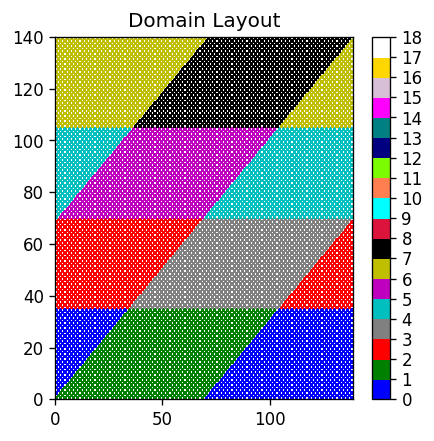

[Domain Number    Number of points]
[[   0 1208]
 [   1 1225]
 [   2 1207]
 [   3 1225]
 [   4 1243]
 [   5 1190]
 [   6 1242]
 [   7 1190]
 [  -5 9730]]


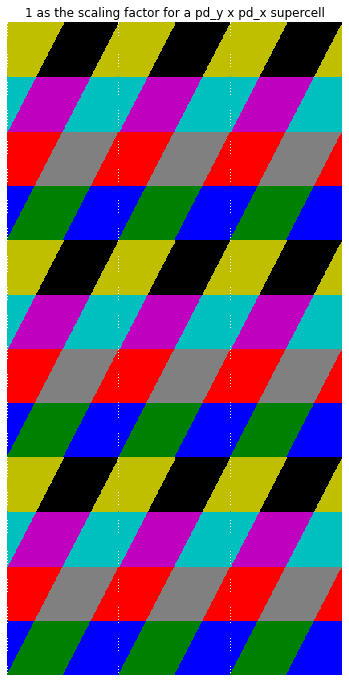

In [329]:
lt = np.unique(J_db_val, return_inverse=True)[1]
print(lt.shape)

J_db_val1 = lt.reshape(yGridSize,xGridSize)
J_db_val_temp = ma.array(J_db_val1,mask=mask_array)
arr = ma.filled(J_db_val_temp,-5)
J_db_val2 = ma.array(wrapJdom(arr),mask=mask_array) 

for i in range (len(np.unique(J_db_val2))-1):
  J_db_val2[J_db_val2 == np.unique(J_db_val2)[i]] = i

levels = [ 0,  1,  2,  3,     4,  5,  6,  7,  8,        9,     10,     11,        12,     13,     14,       15,       16, 17, 18]
colors = ['b','g','r','gray','c','m','y','k','crimson','cyan','coral','lawngreen','navy','teal','fuchsia','thistle','gold','w']
#colors = ['b','b','b','g',   'b','b','b','b','b',      'b',    'b',    'b',       'b',    'g',    'g',      'b',    'b', 'b']
cmap, norm = lc(levels, colors)

figure(num=None, figsize=(4, 4), dpi=120, facecolor='w', edgecolor='k')
pcolormesh(J_db_val2,cmap = cmap,norm=norm)
plt.title('Domain Layout')
plt.colorbar(ticks=levels)
plt.show()



(unique, counts) = np.unique(J_db_val2, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print('[Domain Number    Number of points]')
print(frequencies)

plt.figure(figsize = (6,12))
gs1 = gridspec.GridSpec(3,3)
gs1.update(wspace=0.00, hspace=0.00)
for i in range(3*3):
  #figure(num=None, figsize=(51, 25.5), dpi=120, facecolor='w', edgecolor='k')
  plt.subplot(gs1[i])
  plt.pcolormesh(J_db_val2,cmap=cmap,norm=norm)
  plt.axis('off')
  plt.grid('false')
  if i==1:
    plt.title('%i as the scaling factor for a pd_y x pd_x supercell' %N)
    

In [330]:
print(xGridSize,yGridSize)
print(config.shape)
print((248+2)%699)
#print(config[700][0])

139 140
(140, 139)
250


In [331]:
a = rd (0,yGridSize) 
b = rd (0,xGridSize) 
print(a,b)
print(J_db_val2[a,b])
if (config [a,b] != 0):
  print(frequencies[J_db_val2[a,b]][1])

36 80
3
1225


In [332]:
@jit(nopython=True)
def intxEcalcTri (Lattice,a,b,T):
    #Lattice = ma.filled(Lat,0)
    intrxE = 0 
    J_scale = J_grid_val[a,b]/T
    J_dm_nr = J_db_val2[a,b]
    s = Lattice[a,b]
    """
    print(a,b)
    print((a+2)%yGridSize)
    print((a-2)%yGridSize)
    print((b+2)%xGridSize)
    print((b-2)%xGridSize)
    print((a+1)%yGridSize)
    print((a-1)%yGridSize)
    print((b+1)%xGridSize)
    print((b-1)%xGridSize)    
    """
    if s == 0:
        return 0
    else:
        if Lattice [(a+2)%yGridSize,b] == s:  #W+W
            intrxE += -1
        else:
            intrxE += 1
        if Lattice [(a-2)%yGridSize,b] == s:  #S+S
            intrxE += -1
        else:
            intrxE += 1
        if Lattice [(a+1)%yGridSize,(b+1)%xGridSize] == s: #W+D
            intrxE += -1
        else:
            intrxE += 1
        if Lattice [(a+1)%yGridSize,(b-1)%xGridSize] == s: # W+A
            intrxE += -1
        else:
            intrxE += 1
        if Lattice [(a-1)%yGridSize,(b+1)%xGridSize] == s: #S+D
            intrxE += -1
        else:
            intrxE += 1
        if Lattice [(a-1)%yGridSize,(b-1)%xGridSize] == s: #S+A
            intrxE += -1
        else:
            intrxE += 1
        #print('J value used here = %f' %J_scale)    
    return -J_scale *intrxE

@jit(nopython=True)
def MetropolisMonteCarlo (Lat, T): 
    #Lattice = ma.filled(Lat,0)
    #print('MMC-en = %d,%d' %(Lattice.shape[0],Lattice.shape[1]))
    itr = 512*1
    stored_vals = 10
    #countc1 = 0
    #countc2 = 0
    count = 0
    count_1 = 0
    for j in range (itr): 
        for i in range (itr): 
            count_1 +=1
            a = rd (0,yGridSize) 
            b = rd (0,xGridSize)            
            while (Lat [a,b] == 0): 
              a = rd (0,yGridSize) 
              b = rd (0,xGridSize) 
            intrxE0 = intxEcalcTri (Lat, a, b, T) 
            Lat[a,b] *= -1
            intrxE1 = intxEcalcTri (Lat, a, b, T) 
            random = rand()
            """
            #To check individually which of the two conditions dominate spin flipping
            if (intrxE1-intrxE0) > 0 :
              countc1+= 1
            if random > np.exp(-(intrxE1-intrxE0)/T):
              countc2+=1
            """
            if (intrxE1-intrxE0) > 0 and random > np.exp(-(intrxE1-intrxE0)/T): #if the current spin config (post flip calculation) is greater energy than original, then flip back to original
                Lat[a,b] *=-1
                count+=1
    #Lat_return = ma.array(Lattice,mask=mask_array)
    #print('MMC_ex = %d,%d' %(Lat_return.shape[0],Lat_return.shape[1]))
    #return Lat, count, count_1, countc1, countc2
    return Lat

Transformed_Lattice = MetropolisMonteCarlo(config,1.5)


#Transformed_Lattice, count, count_1, countc1, countc2 = MetropolisMonteCarlo (config, 1.5) 
#print('Succesful flips = %d out of total attempts = %d' %(count_1-count,count_1))
#print('Condition 1 satisfied for %d of %d and condition 2 satisfied for %d of %d' %(countc1,count_1,countc2,count_1))



In [333]:
@jit(nopython=True)
def DomAvgMagCalc (Lattice,Nr):
  #Lattice = ma.filled(Lat,0)
  indx = np.argwhere(J_db_val2 == Nr) 
  mag = 0
  for i in range (len(indx)):
    y,x = indx[i][0], indx[i][1]
    mag+= Lattice[y][x]
  return (mag/frequencies[Nr][1])

print(config.shape)

@jit(nopython=True)
def DomSqMagCalc (Lattice, yGs, xGs, Nr):
  #Lattice = ma.filled(Lat,0)
  indx = np.argwhere(J_db_val2 == Nr) 
  mag_sq = 0
  for i in range(len(indx)):
    y,x = indx[i][0], indx[i][1]
    mag_sq += Lattice[y][x]*Lattice[y][x]
  return (mag_sq/frequencies[Nr][1])

@jit(nopython=True)
def DomSqEneCalc (Lattice,yGs, xGs,T, Nr): 
    indx = np.argwhere(J_db_val2 == Nr) 
    Ene_sq = 0 
    #Lattice = ma.filled(Lat,0)
    for i in range(len(indx)):
      y,x = indx[i][0], indx[i][1]
      Ene_sq += intxEcalcTri(Lattice,y,x,T)*intxEcalcTri(Lattice,y,x,T) 
    return (Ene_sq/frequencies[Nr][1]) 

@jit(nopython=True)
def DomEnergyCalc (Lattice,yGs, xGs,T, Nr): 
    indx = np.argwhere(J_db_val2 == Nr) 
    sum = 0 
    #Lattice = ma.filled(Lat,0)
    temp = np.zeros(len(indx)) 
    for i in range(len(indx)):
      y,x = indx[i][0], indx[i][1]
      temp[i] = intxEcalcTri(Lattice,y,x,T)  
    ans = np.sum(temp)/(frequencies[Nr][1])
    return ans 

(140, 139)


In [334]:
@jit(nopython=True)
def AvgMagCalc (Lattice): 
    #Lattice = ma.filled(Lat,0)
    mag = 0 
    mag = np.sum (Lattice)/(sites) 
    return mag 

@jit(nopython=True) 
def SqMagCalc (Lattice,yGs, xGs): 
    mag_sq = 0
    #Lattice = ma.filled(Lat,0)
    #print('Sqmagcalc = %d,%d' %(Lattice.shape[0],Lattice.shape[1])) 
    for i in range (yGs): 
        for j in range (xGs): 
            mag_sq += Lattice[i,j]*Lattice[i,j] 
    return mag_sq/(sites) 
 
@jit(nopython=True) 
def SqEneCalc (Lattice,yGs, xGs,T): 
    Ene_sq = 0 
    #Lattice = ma.filled(Lat,0)
    for i in range (yGs): 
        for j in range (xGs): 
            Ene_sq += intxEcalcTri(Lattice,i,j,T)*intxEcalcTri(Lattice,i,j,T) 
    return Ene_sq/(sites) 
 
@jit(nopython=True) 
def EnergyCalc (Lattice,yGs, xGs,T): 
    sum = 0 
    #Lattice = ma.filled(Lat,0)
    temp = np.zeros((yGs, xGs)) 
    for i in range (yGs): 
        for j in range (xGs): 
            temp[i][j] = intxEcalcTri(Lattice,i,j,T)  
    ans = np.sum (temp)/(sites) 
    return ans 


Number of sites = 9730


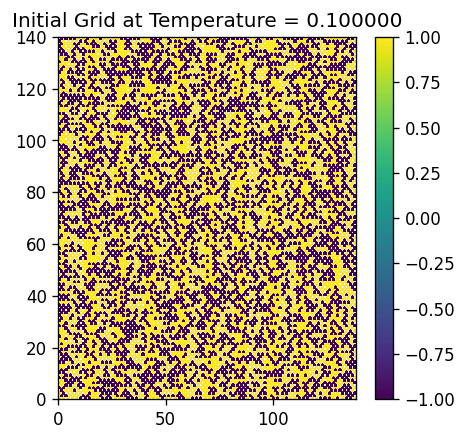

--- 1.2050964832305908 seconds --- and 0 out of 100 loops done
--- 1.2548532485961914 seconds --- and 1 out of 100 loops done
--- 1.304011344909668 seconds --- and 2 out of 100 loops done
--- 1.3533554077148438 seconds --- and 3 out of 100 loops done
--- 1.402925968170166 seconds --- and 4 out of 100 loops done
--- 1.46234130859375 seconds --- and 5 out of 100 loops done
--- 1.5117909908294678 seconds --- and 6 out of 100 loops done
--- 1.5604603290557861 seconds --- and 7 out of 100 loops done
--- 1.608314037322998 seconds --- and 8 out of 100 loops done
--- 1.6564819812774658 seconds --- and 9 out of 100 loops done
--- 1.708292007446289 seconds --- and 10 out of 100 loops done
--- 1.7586960792541504 seconds --- and 11 out of 100 loops done
--- 1.8066043853759766 seconds --- and 12 out of 100 loops done
--- 1.8549268245697021 seconds --- and 13 out of 100 loops done
--- 1.9076621532440186 seconds --- and 14 out of 100 loops done
--- 1.9664969444274902 seconds --- and 15 out of 100 loo

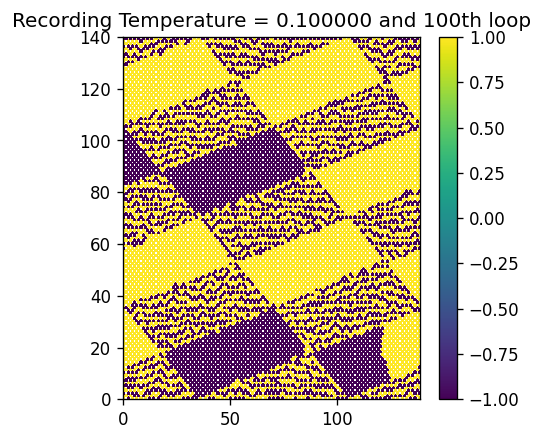

--- 2853.2574441432953 seconds ---


In [335]:
plt.ioff()

myTval = np.linspace(0.1,0.1,1) 
N_loops = 100
config = GenerateTriLattice(xGridSize,yGridSize)[0]
sites = np.count_nonzero(config)/2 
print ('Number of sites = %d' %sites) 
bank_mag = np.zeros((len(myTval),N_loops)) 
bank_susc = np.zeros((len(myTval),N_loops)) 
bank_Cv = np.zeros((len(myTval),N_loops)) 
bank_dom_mag = np.zeros((len(myTval),len(unique)-2)) 
bank_dom_susc = np.zeros((len(myTval),len(unique)-2)) 
bank_dom_Cv = np.zeros((len(myTval),len(unique)-2)) 
#figure(num=None, figsize=(32, 24), dpi=120, facecolor='w', edgecolor='k')
#graph(config, tile) 
 
for i in range (len(myTval)): 
    tempo_mag = np.zeros(N_loops, dtype=float) 
    tempo_Cv = np.zeros(N_loops, dtype=float) 
    tempo_susc = np.zeros(N_loops, dtype=float) 
    tempo_dom_mag = np.zeros(len(unique)-2, dtype=float)
    tempo_dom_Cv = np.zeros(len(unique)-2, dtype=float)
    tempo_dom_susc = np.zeros(len(unique)-2, dtype=float)
    config = GenerateTriLattice(yGridSize,xGridSize)[0] 
    start_time1 = time.time() 
    #print('f1 = %d,%d' %(config.shape[0],config.shape[1]))
    figure(num=None, figsize=(4, 4), dpi=120, facecolor='w', edgecolor='k')
    pcolormesh(config)
    plt.colorbar()
    plt.title('Initial Grid at Temperature = %f' %myTval[i])
    plt.show()
    for m in range (N_loops): 
        config = MetropolisMonteCarlo(ma.filled(config,0), myTval[i])
        config_plot = ma.array(config,mask=mask_array)
        #print('f2 = %d,%d' %(config.shape[0],config.shape[1]))
        #print("--- %s T ---" % (myTval[i])) 
        #print("--- %s M ---" % (MagCalc(config)/(N*N))) 
        tempo_mag [m] = AvgMagCalc(config) 
        tempo_susc [m] = (1/myTval[i])*(SqMagCalc(config,yGridSize,xGridSize)-AvgMagCalc(config)*AvgMagCalc(config)) 
        tempo_Cv [m] = (1/(myTval[i]*myTval[i]))*(SqEneCalc(config,yGridSize,xGridSize,myTval[i])-EnergyCalc(config,yGridSize,xGridSize,myTval[i])*EnergyCalc(config,yGridSize,xGridSize,myTval[i])) 
        if (m%1 == 0):
          print("--- %s seconds --- and %d out of %d loops done" %(time.time() - start_time1,m,N_loops))
        if (m==(N_loops-1)):
          for z in range (len(unique)-2):
            tempo_dom_mag [z] = DomAvgMagCalc(config,z)
            tempo_dom_susc [z] = (1/myTval[i])*(DomSqMagCalc(config,yGridSize,xGridSize,z)-DomAvgMagCalc(config,z)*DomAvgMagCalc(config,z)) 
            tempo_dom_Cv [z] = (1/(myTval[i]*myTval[i]))*(DomSqEneCalc(config,yGridSize,xGridSize,myTval[i],z)-DomEnergyCalc(config,yGridSize,xGridSize,myTval[i],z)*DomEnergyCalc(config,yGridSize,xGridSize,myTval[i],z)) 
          #figure(num=None, figsize=(32, 24), dpi=120, facecolor='w', edgecolor='k')
          figure(num=None, figsize=(4, 4), dpi=120, facecolor='w', edgecolor='k')
          #pcolormesh(J_db_val2)
          pcolormesh(config_plot)
          plt.colorbar()
          plt.title('Recording Temperature = %f and %dth loop' %(myTval[i],m+1))
          #plt.savefig("/content/IsingPlots/plot" + str (myTval[i]) + "_" + str (m) + ".png")
          #plt.close()
          plt.show()
    print("--- %s seconds ---" % (time.time() - start_time)) 
    bank_mag [i] = tempo_mag 
    bank_susc [i] = tempo_susc 
    bank_Cv [i]  = tempo_Cv 
    bank_dom_mag [i] = tempo_dom_mag 
    bank_dom_susc [i] = tempo_dom_susc 
    bank_dom_Cv [i]  = tempo_dom_Cv 


In [ ]:
!zip -r /content/files.zip /content/IsingPlots

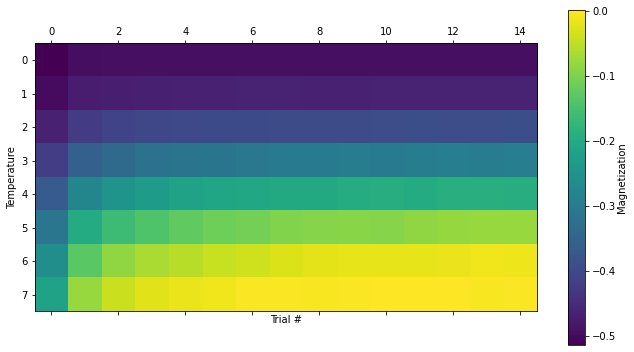

[-0.49383721 -0.46840872 -0.4021908  -0.31600761 -0.22034014 -0.12272279
 -0.05343918 -0.02564569]


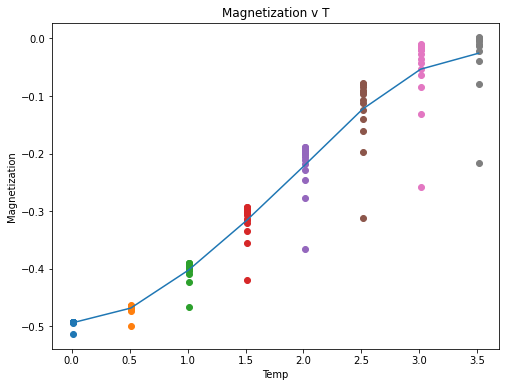

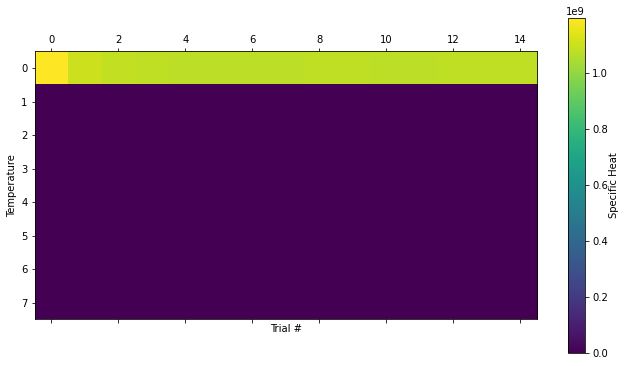

[1.08993980e+09 1.62380861e+02 1.11186493e+01 2.44473559e+00
 8.07222051e-01 2.81673133e-01 1.00785971e-01 4.64848521e-02]


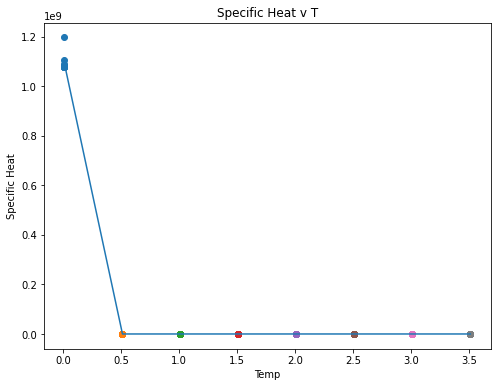

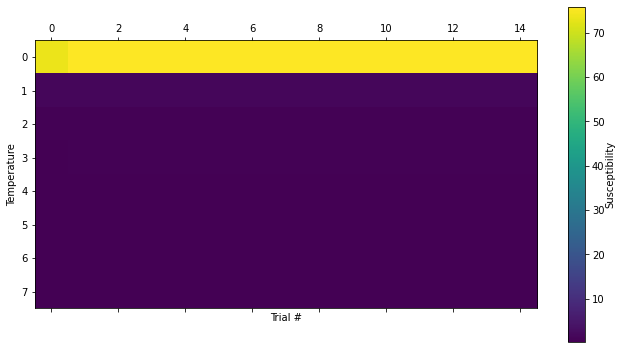

[75.60971967  1.53043355  0.82958597  0.59542431  0.47233633  0.39096836
  0.32994283  0.28384572]


<function matplotlib.pyplot.show>

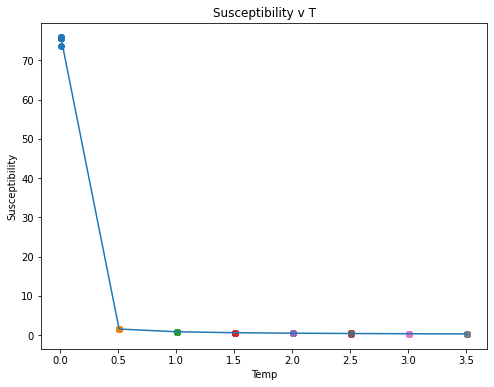

In [245]:
plt.matshow(bank_mag) 
plt.xlabel("Trial #") 
plt.ylabel("Temperature") 
cbar= plt.colorbar() 
cbar.set_label("Magnetization", labelpad=+1) 
plt.show() 
 
bank_avg_mag = np.zeros(len(myTval)) 
for i in range (len(myTval)): 
    bank_avg_mag[i] = np.average(bank_mag[i,:]) 
print (bank_avg_mag) 
 
for i in range (len(myTval)): 
    temp = np.full(N_loops,myTval[i]) 
    plt.scatter(temp, bank_mag[i]) 
plt.plot (myTval,bank_avg_mag) 
plt.title ("Magnetization v T") 
plt.xlabel("Temp") 
plt.ylabel("Magnetization") 
plt.show 
 
plt.matshow(bank_Cv) 
plt.xlabel("Trial #") 
plt.ylabel("Temperature") 
cbar= plt.colorbar() 
cbar.set_label("Specific Heat", labelpad=+1) 
plt.show() 
 
bank_avg_Cv = np.zeros(len(myTval)) 
for i in range (len(myTval)): 
    bank_avg_Cv[i] = np.average(bank_Cv[i,:]) 
print (bank_avg_Cv) 
 
for i in range (len(myTval)): 
    temp = np.full(N_loops,myTval[i]) 
    plt.scatter(temp, bank_Cv[i]) 
plt.plot (myTval,bank_avg_Cv) 
plt.title ("Specific Heat v T") 
plt.xlabel("Temp") 
plt.ylabel("Specific Heat") 
plt.show 
 
plt.matshow(bank_susc) 
plt.xlabel("Trial #") 
plt.ylabel("Temperature") 
cbar= plt.colorbar() 
cbar.set_label("Susceptibility", labelpad=+1) 
plt.show() 
 
bank_avg_susc = np.zeros(len(myTval)) 
for i in range (len(myTval)): 
    bank_avg_susc[i] = np.average(bank_susc[i,:]) 
print (bank_avg_susc) 
 
for i in range (len(myTval)): 
    temp = np.full(N_loops,myTval[i]) 
    plt.scatter(temp, bank_susc[i]) 
plt.plot (myTval,bank_avg_susc) 
plt.title ("Susceptibility v T") 
plt.xlabel("Temp") 
plt.ylabel("Susceptibility") 
plt.show 



In [246]:
from math import atan2,degrees
import numpy as np

#Label line with line2D label data
def labelLine(line,x,label=None,align=True,**kwargs):

    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if (x < xdata[0]) or (x > xdata[-1]):
        print('x label location is outside data range!')
        return

    #Find corresponding y co-ordinate and angle of the line
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break

    y = ydata[ip-1] + (ydata[ip]-ydata[ip-1])*(x-xdata[ip-1])/(xdata[ip]-xdata[ip-1])

    if not label:
        label = line.get_label()

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0

    #Set a bunch of keyword arguments
    if 'color' not in kwargs:
        kwargs['color'] = line.get_color()

    if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
        kwargs['ha'] = 'center'

    if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
        kwargs['va'] = 'center'

    if 'backgroundcolor' not in kwargs:
        kwargs['backgroundcolor'] = ax.get_facecolor()

    if 'clip_on' not in kwargs:
        kwargs['clip_on'] = True

    if 'zorder' not in kwargs:
        kwargs['zorder'] = 2.5

    ax.text(x,y,label,rotation=trans_angle,**kwargs)

def labelLines(lines,align=True,xvals=None,**kwargs):

    ax = lines[0].axes
    labLines = []
    labels = []

    #Take only the lines which have labels other than the default ones
    for line in lines:
        label = line.get_label()
        if "_line" not in label:
            labLines.append(line)
            labels.append(label)

    if xvals is None:
        xmin,xmax = ax.get_xlim()
        xvals = np.linspace(xmin,xmax,len(labLines)+2)[1:-1]

    for line,x,label in zip(labLines,xvals,labels):
        labelLine(line,x,label,align,**kwargs)

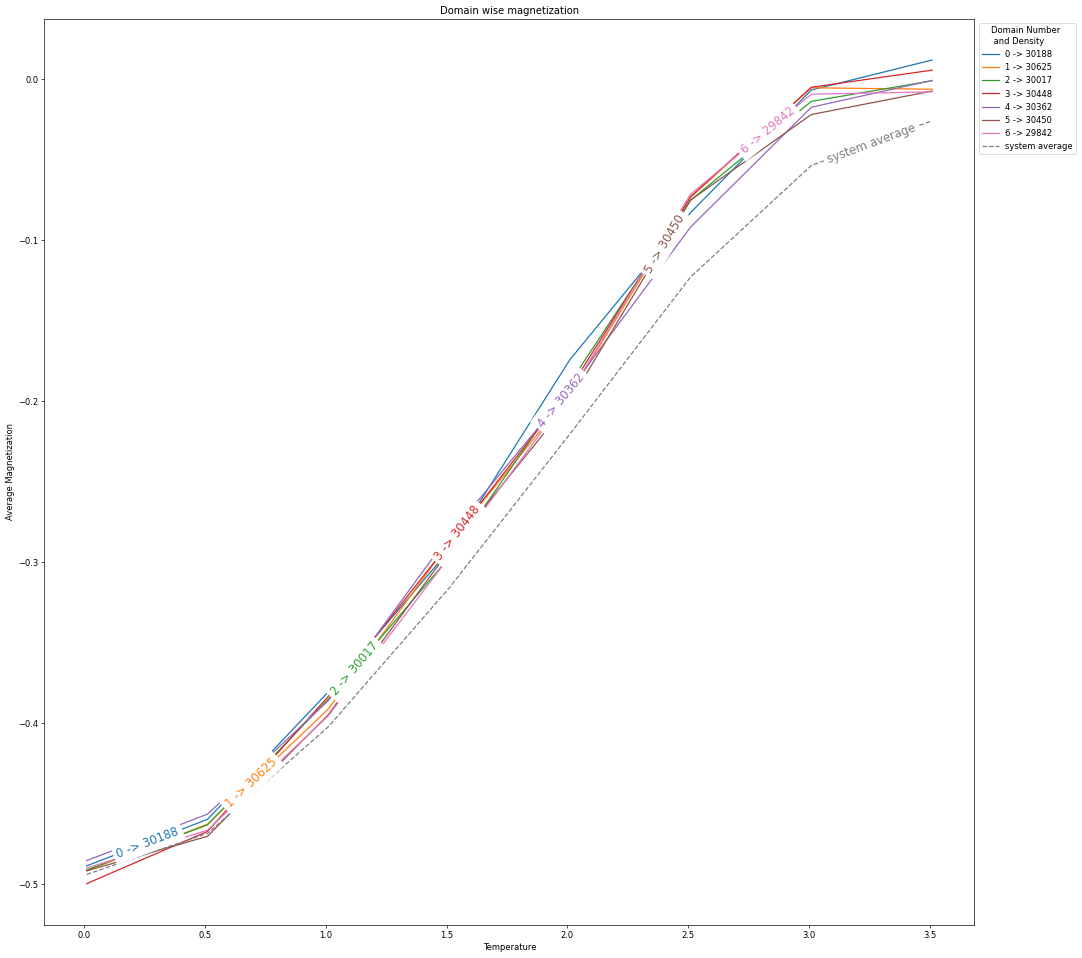

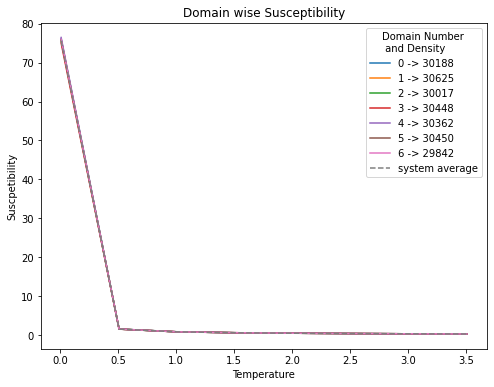

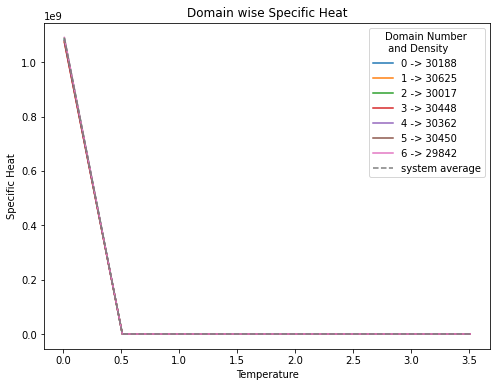

In [247]:
style = dict(size=12, color='black')
figure(num=None, figsize=(20,20), dpi=60, facecolor='w', edgecolor='k')
for i in range(len(unique)-2):
  if (frequencies[i][1] < 1000):
    continue
  else:
    plt.plot(myTval, bank_dom_mag[:,i],label='%d -> %d' %(i,frequencies[i][1]))
plt.plot (myTval,bank_avg_mag,'--',label='system average') 
labelLines(plt.gca().get_lines(),zorder=2.5, fontsize = 14)
plt.xlabel('Temperature')
plt.ylabel('Average Magnetization')
plt.title('Domain wise magnetization')
plt.legend(title='Domain Number \n and Density',bbox_to_anchor=(1, 1),fancybox='True')
plt.show()

for i in range(len(unique)-2):
  if (frequencies[i][1] < 1000):
    continue
  else:
    plt.plot(myTval, bank_dom_susc[:,i],label='%d -> %d' %(i,frequencies[i][1]))
plt.plot (myTval,bank_avg_susc,'--',label='system average') 
plt.title('Domain wise Susceptibility')
plt.xlabel('Temperature')
plt.ylabel('Suscpetibility')
plt.legend(title='Domain Number \n and Density',bbox_to_anchor=(1, 1),fancybox='True')
plt.show()

for i in range(len(unique)-2):
  if (frequencies[i][1] < 1000):
    continue
  else:
    plt.plot(myTval, bank_dom_Cv[:,i],label='%d -> %d' %(i,frequencies[i][1]))
plt.plot (myTval,bank_avg_Cv,'--',label='system average') 
plt.xlabel('Temperature')
plt.ylabel('Specific Heat')
plt.title('Domain wise Specific Heat')
plt.legend(title='Domain Number \n and Density',bbox_to_anchor=(1, 1),fancybox='True')
plt.show()


In [ ]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Untitled4.ipynb')